## Importing relevant libraries

In [198]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

### data 

In [199]:
data = pd.read_csv('./nlp-getting-started/train.csv', encoding='utf-8')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### Data cleaning

In [200]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires california even northern part state troubling,1
7610,10871,NaN,NaN,volcano hawaii,1
7611,10872,NaN,NaN,police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...,1


In [201]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

In [202]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [203]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<6851x15374 sparse matrix of type '<class 'numpy.int64'>'
	with 59212 stored elements in Compressed Sparse Row format>

In [204]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

cooking earlier got electrocuted crucial im psychic lol
[1413, 28, 358, 3, 82]


In [205]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [206]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [207]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('./nlp-getting-started/glove.twitter.27B/glove.twitter.27B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [208]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 50)           769850    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 11        
Total params: 770,371
Trainable params: 521
Non-trainable params: 769,850
_________________________________________________________________


In [209]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [210]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])


Epoch 1/50
686/686 [==============================] - 3s 5ms/step - loss: 0.6310 - accuracy: 0.6446 - precision: 0.5890 - recall: 0.5635 - val_loss: 0.5636 - val_accuracy: 0.7323 - val_precision: 0.7870 - val_recall: 0.5387
Epoch 2/50
686/686 [==============================] - 3s 5ms/step - loss: 0.5298 - accuracy: 0.7427 - precision: 0.7120 - recall: 0.6705 - val_loss: 0.5153 - val_accuracy: 0.7598 - val_precision: 0.7084 - val_recall: 0.7738
Epoch 3/50
686/686 [==============================] - 3s 4ms/step - loss: 0.5106 - accuracy: 0.7592 - precision: 0.7305 - recall: 0.6937 - val_loss: 0.5174 - val_accuracy: 0.7572 - val_precision: 0.8159 - val_recall: 0.5804
Epoch 00003: early stopping


In [211]:
glove_model = model.to_json()
with open('./NN_Models/glove_mlp_model.json', 'w') as json_file:
    json_file.write(glove_model)

model.save_weights('./NN_Models/glove_mlp_model.h5')

print('saved model!')

saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


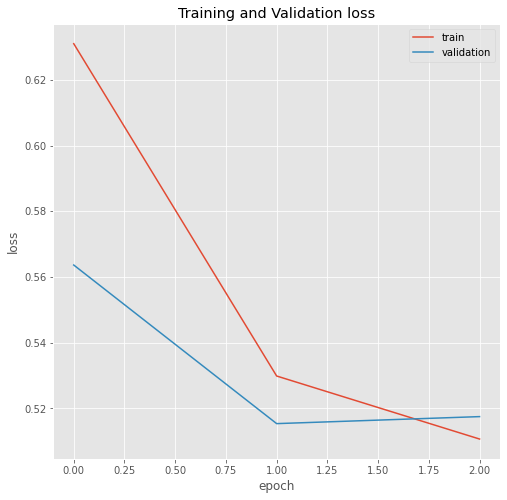

In [212]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [213]:
model.evaluate(X_train, y_train, verbose=False)


[0.5168763995170593,
 0.7527368068695068,
 0.8019464612007141,
 0.5614991188049316]

In [214]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=False)

In [215]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,382,44
Positive,141,195


In [216]:
results

,Value
Accuracy,0.757218
Precision,0.815900
FPR,0.103286
Recall,0.580357
F1,0.678261


## Summary

- Accuracy and precision increased by just 1%
- Recall also improved by 2%
- F1 has also slightly increased
- This model is slightly better than the keras embedding layer model

### explore

- try and find a location in a tweet text and see if we can match that to the location column.
- be careful with places like east london.
- see if the user is within the radius of the location in the tweet itself(i.e. if a user retweets from melville about a tweet in braamfontein it could be legit, but it is not if the user is in london).

- tweets with mislabels: exclude these since they might hurt our model.


### Word2vec

In [217]:
data2 = data_without_tockenization.copy()

In [218]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [219]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [220]:
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [221]:
y_train

array([0, 1, 0, ..., 0, 1, 1])

In [222]:

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data2.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

tockenized_data.head()

tweet_data = tockenized_data['text']
tweet_data[1]

tweet_data_array = []

for arr in tweet_data:
    tweet_data_array.append(arr)

In [231]:
# train word2vec model
model = Word2Vec(sentences=tweet_data_array, size=100, window=5, workers=3, min_count=1,
                 negative=20, iter=50,seed=1000)
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))
 
# word2vec_self_trained = Word2Vec(sentences=tweet_data_array,
#                     size=vector_size, 
#                     window=window_size, 
#                     negative=20,
#                     iter=50,
#                     seed=1000,
#                     workers=3)
    
    
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 16435


In [232]:
# load embedding as a dict
def load_embedding(filename):
# load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [233]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [234]:

# load embedding from file
raw_embedding = load_embedding('embedding_word2vec.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [235]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 138, 100)          1539700   
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 11        
Total params: 1,540,721
Trainable params: 1,021
Non-trainable params: 1,539,700
_________________________________________________________________


In [237]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

Epoch 1/50
193/193 [==============================] - 1s 6ms/step - loss: 0.4803 - accuracy: 0.7770 - precision: 0.7610 - recall: 0.6959 - val_loss: 0.5163 - val_accuracy: 0.7595 - val_precision: 0.8035 - val_recall: 0.6053
Epoch 2/50
193/193 [==============================] - 1s 6ms/step - loss: 0.4779 - accuracy: 0.7757 - precision: 0.7609 - recall: 0.6918 - val_loss: 0.5158 - val_accuracy: 0.7609 - val_precision: 0.7991 - val_recall: 0.6151
Epoch 3/50
193/193 [==============================] - 1s 5ms/step - loss: 0.4755 - accuracy: 0.7791 - precision: 0.7694 - recall: 0.6887 - val_loss: 0.5049 - val_accuracy: 0.7580 - val_precision: 0.7695 - val_recall: 0.6480
Epoch 4/50
193/193 [==============================] - 1s 5ms/step - loss: 0.4721 - accuracy: 0.7828 - precision: 0.7754 - recall: 0.6914 - val_loss: 0.5046 - val_accuracy: 0.7536 - val_precision: 0.7455 - val_recall: 0.6743
Epoch 5/50
193/193 [==============================] - 1s 5ms/step - loss: 0.4714 - accuracy: 0.7818 - pr

In [238]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,350,76
Positive,148,188


In [239]:
results

,Value
Accuracy,0.706037
Precision,0.712121
FPR,0.178404
Recall,0.559524
F1,0.626667


# Simple RNN

In [20]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           769850    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 128)          22912     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 805,179
Trainable params: 35,329
Non-trainable params: 769,850
___________________________________________

In [22]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])


In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

In [ ]:
results